In [217]:
# Imports

# Data manipulation
import pandas as pd
import numpy as np
from math import pi
from collections import Counter, defaultdict
from itertools import pairwise
import os
import time

# Date/time environment
from dotenv import load_dotenv

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import matplotlib.colors as mcolors
from matplotlib_venn import venn3

# Graph/network analysis
import networkx as nx

# Spotify API
import spotipy
from spotipy.oauth2 import SpotifyOAuth

# Typing and encoding
from pandas.api.types import CategoricalDtype
from sklearn.preprocessing import LabelEncoder

# Machine learning
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Geographic data
import pycountry
import requests

# Notebook configuration (if in Jupyter)
%matplotlib inline


In [218]:
# Load environment variables from log.env
load_dotenv(dotenv_path="log.env")

# Set up Spotipy with env credentials
sp = spotipy.Spotify(auth_manager=SpotifyOAuth(
    client_id=os.getenv("SPOTIPY_CLIENT_ID"),
    client_secret=os.getenv("SPOTIPY_CLIENT_SECRET"),
    redirect_uri=os.getenv("SPOTIPY_REDIRECT_URI"),
    scope="user-top-read user-library-read user-read-recently-played playlist-read-private",
    show_dialog=True
))

# Test connection
user = sp.current_user()
print(f"Connected as: {user['display_name']} ({user['id']})")

Connected as: Victor Brivet (victor.brivet)


In [219]:
def fetch_top_data(sp, time_range='long_term', limit=50):
    """
    Fetch top tracks and top artists from Spotify API for a given time range.

    Parameters:
        sp: Authenticated Spotipy client.
        time_range (str): 'short_term', 'medium_term', or 'long_term'.
        limit (int): Number of top items to fetch.

    Returns:
        df_top_tracks (DataFrame): Top tracks with duration in minutes.
        df_top_artists (DataFrame): Top artists with genres, popularity, and followers.
    """

    # Fetch top tracks
    results_tracks = sp.current_user_top_tracks(limit=limit, time_range=time_range)
    top_tracks = []
    for item in results_tracks['items']:
        top_tracks.append({
            'name': item['name'],
            'artist': item['artists'][0]['name'],
            'album': item['album']['name'],
            'popularity': item['popularity'],
            'duration_ms': item['duration_ms'],
            'id': item['id']
        })

    df_top_tracks = pd.DataFrame(top_tracks)
    df_top_tracks['duration_min'] = df_top_tracks['duration_ms'] / 60000

    # Fetch top artists
    results_artists = sp.current_user_top_artists(limit=limit, time_range=time_range)
    top_artists = []
    for item in results_artists['items']:
        top_artists.append({
            'name': item['name'],
            'genres': item['genres'],
            'popularity': item['popularity'],
            'followers': item['followers']['total'],
            'id': item['id']
        })

    df_top_artists = pd.DataFrame(top_artists)

    return df_top_tracks, df_top_artists


In [220]:
# Prompt user for time range
selected_range = input("Choose time range (short_term, medium_term, long_term): ").strip()
df_top_tracks, df_top_artists = fetch_top_data(sp, time_range=selected_range)


In [221]:
# Genre mapping
genre_map = {
    "tech": "techno",
    "house": "house",
    "rap": "rap",
    "drill": "drill",
    "pop": "pop",
    "rock": "rock"
}

def part_of_day(hour):
    if 5 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 17:
        return 'Afternoon'
    elif 17 <= hour < 22:
        return 'Evening'
    else:
        return 'Night'

In [222]:
# Basic descriptive statistics for top tracks

print("Number of tracks:", len(df_top_tracks))
print("Number of unique artists:", df_top_tracks['artist'].nunique())

# Convert duration to minutes if not already done
if 'duration_min' not in df_top_tracks.columns:
    df_top_tracks['duration_min'] = df_top_tracks['duration_ms'] / 60000

# Summary statistics
print("\n--- Popularity ---")
print(df_top_tracks['popularity'].describe())

print("\n--- Duration (minutes) ---")
print(df_top_tracks['duration_min'].describe())

# Longest and shortest tracks
longest = df_top_tracks.loc[df_top_tracks['duration_min'].idxmax()]
shortest = df_top_tracks.loc[df_top_tracks['duration_min'].idxmin()]

print("\nLongest track:", longest['name'], "by", longest['artist'], f"({longest['duration_min']:.2f} min)")
print("Shortest track:", shortest['name'], "by", shortest['artist'], f"({shortest['duration_min']:.2f} min)")


Number of tracks: 50
Number of unique artists: 37

--- Popularity ---
count    50.000000
mean     47.540000
std      27.560849
min       1.000000
25%      29.750000
50%      53.000000
75%      68.000000
max      93.000000
Name: popularity, dtype: float64

--- Duration (minutes) ---
count    50.000000
mean      4.525512
std       1.939619
min       2.329550
25%       3.119608
50%       4.166642
75%       5.134658
max      13.504883
Name: duration_min, dtype: float64

Longest track: Shine On You Crazy Diamond, Pts. 1-5 - 2011 Remaster by Pink Floyd (13.50 min)
Shortest track: Vois sur ton chemin by Bruno Coulais (2.33 min)


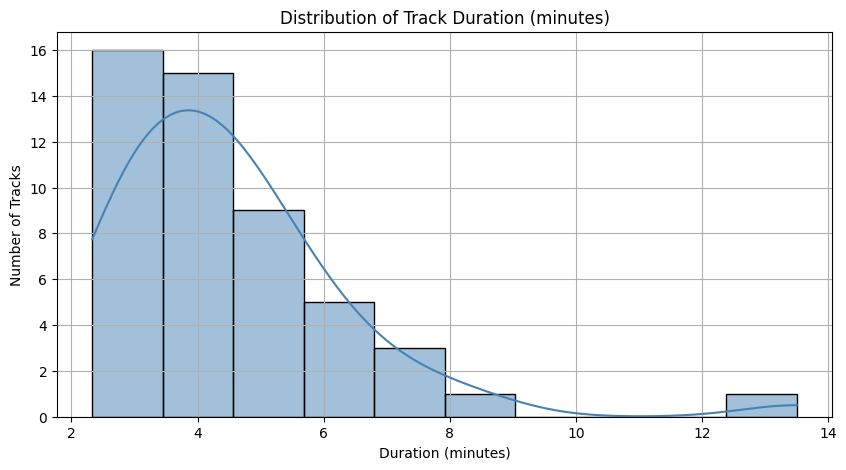

In [223]:
#Distribution of Track Duration 
plt.figure(figsize=(10, 5))
sns.histplot(df_top_tracks['duration_min'], bins=10, kde=True, color="steelblue")
plt.title("Distribution of Track Duration (minutes)")
plt.xlabel("Duration (minutes)")
plt.ylabel("Number of Tracks")
plt.grid(True)
plt.show()

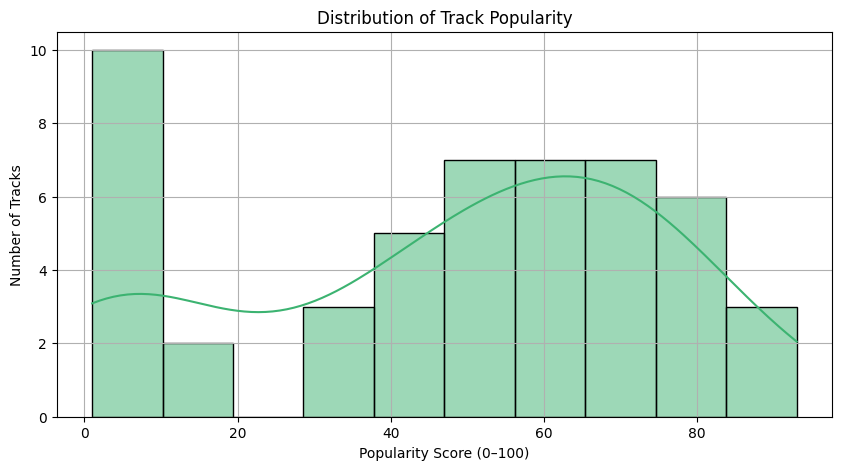

 
Popularity statistics:
count    50.000000
mean     47.540000
std      27.560849
min       1.000000
25%      29.750000
50%      53.000000
75%      68.000000
max      93.000000
Name: popularity, dtype: float64
 
Correlation between popularity and duration: -0.292


In [224]:
# Distribution of Track Popularity
plt.figure(figsize=(10, 5))
sns.histplot(df_top_tracks['popularity'], bins=10, kde=True, color='mediumseagreen')
plt.title("Distribution of Track Popularity")
plt.xlabel("Popularity Score (0–100)")
plt.ylabel("Number of Tracks")
plt.grid(True)
plt.show()
print(" ")
print("Popularity statistics:")
print(df_top_tracks['popularity'].describe())
print(" ")
correlation = df_top_tracks['popularity'].corr(df_top_tracks['duration_min'])
print(f"Correlation between popularity and duration: {correlation:.3f}")



Number of unique artists in top tracks: 37

Top artists by frequency:
artist
Pink Floyd      9
Alpha Blondy    2
Jacques Brel    2
Norah Jones     2
Portishead      2
Name: count, dtype: int64



/var/folders/mv/wk6vx0xn40s4hyxqzh2g2qnm0000gn/T/ipykernel_50088/970975781.py:11: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




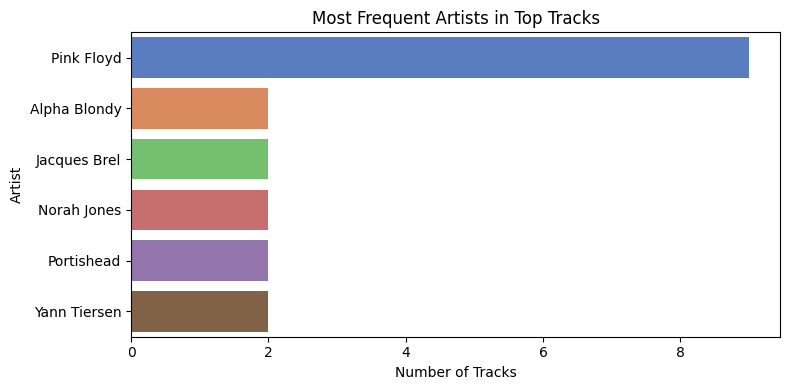

In [225]:
num_artists = df_top_tracks['artist'].nunique()
print(f"Number of unique artists in top tracks: {num_artists}")
print("")
artist_counts = df_top_tracks['artist'].value_counts()
print("Top artists by frequency:")
print(artist_counts.head())
print("")
top_artists = artist_counts[artist_counts > 1]  # Only artists appearing more than once

plt.figure(figsize=(8, 4))
sns.barplot(x=top_artists.values, y=top_artists.index, palette='muted')
plt.title("Most Frequent Artists in Top Tracks")
plt.xlabel("Number of Tracks")
plt.ylabel("Artist")
plt.tight_layout()
plt.show()


In [226]:
df_top_tracks.sort_values(by="popularity", ascending=False)[['name', 'artist', 'popularity']].head(10)

,name,artist,popularity
13,Creep,Radiohead,93
35,Hotel California - 2013 Remaster,Eagles,88
26,Zombie,The Cranberries,87
49,Don't Know Why,Norah Jones,80
21,Glory Box,Portishead,79
28,Come Away With Me,Norah Jones,76
14,"i hate u, i love u (feat. olivia o'brien)",gnash,76
4,"Comptine d'un autre été, l'après-midi",Yann Tiersen,75
22,Back To Black,Amy Winehouse,75
2,Hallelujah,Jeff Buckley,73


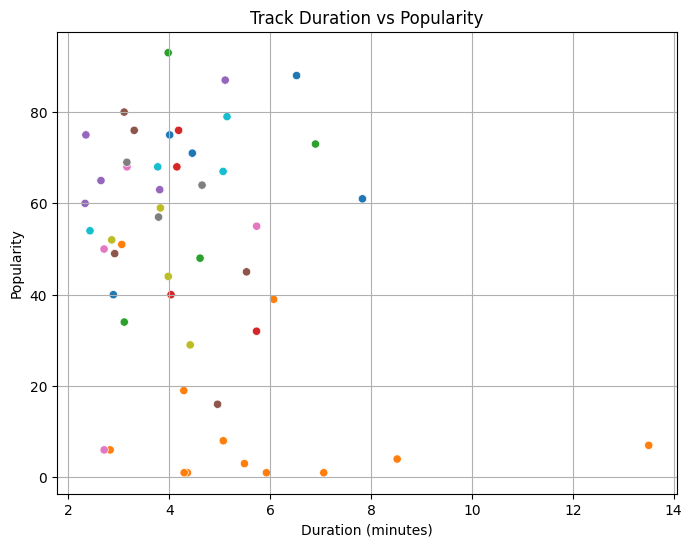

In [227]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_top_tracks, x="duration_min", y="popularity", hue="artist", palette="tab10", legend=False)
plt.title("Track Duration vs Popularity")
plt.xlabel("Duration (minutes)")
plt.ylabel("Popularity")
plt.grid(True)
plt.show()


In [228]:
sns.jointplot(data=df_top_tracks, x="duration_min", y="popularity", kind="hex", color="skyblue")


In [229]:
df_top_tracks.sort_values(by="popularity", ascending=False)[['name', 'artist', 'duration_min', 'popularity']].head(5)


,name,artist,duration_min,popularity
13,Creep,Radiohead,3.977333,93
35,Hotel California - 2013 Remaster,Eagles,6.522933,88
26,Zombie,The Cranberries,5.107333,87
49,Don't Know Why,Norah Jones,3.104183,80
21,Glory Box,Portishead,5.143767,79


In [230]:
# Normalize and group genres per artist without duplicates
all_genres = []

for sublist in df_top_artists['genres']:
    normalized = set()
    for genre in sublist:
        genre_lower = genre.lower()
        matched = False
        for keyword, label in genre_map.items():
            if keyword in genre_lower:
                normalized.add(label)
                matched = True
                break
        if not matched:
            normalized.add(genre_lower)
    all_genres.extend(normalized)  # add the normalized genres for each artist

# Count genre occurrences
genre_counts = pd.DataFrame(Counter(all_genres).most_common(), columns=["genre", "count"])
genre_counts


,genre,count
0,rap,14
1,pop,11
2,rock,6
3,house,4
4,chanson,4
5,drill,4
6,trip hop,3
7,french r&b,3
8,variété française,3
9,classical,2


/var/folders/mv/wk6vx0xn40s4hyxqzh2g2qnm0000gn/T/ipykernel_50088/794057623.py:5: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




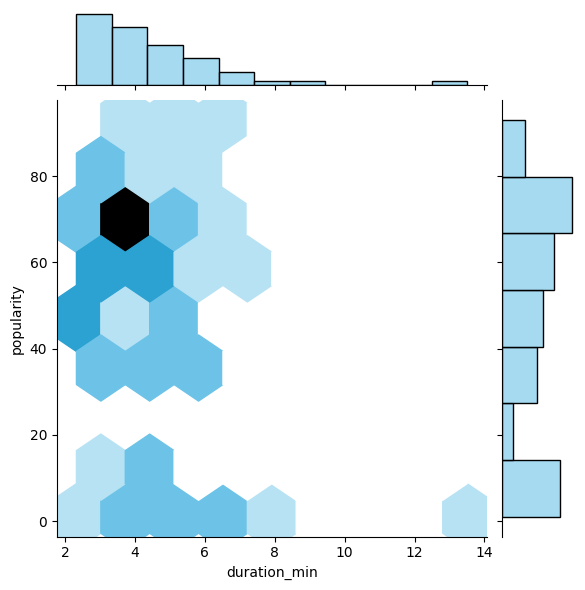

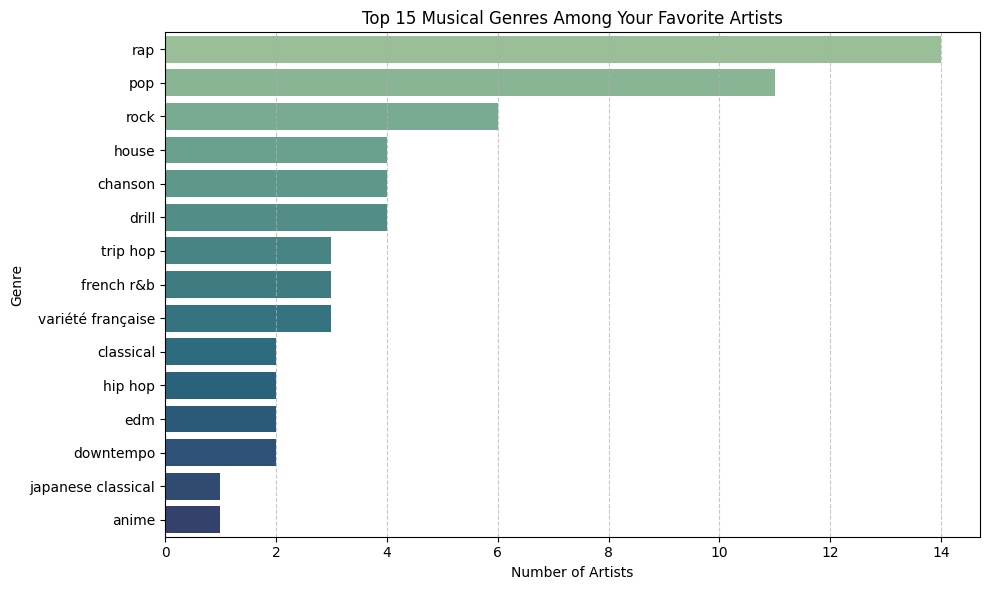

In [231]:
# Top 15 genres
top_genres = genre_counts.head(15)

plt.figure(figsize=(10, 6))
sns.barplot(data=top_genres, y="genre", x="count", palette="crest")
plt.title("Top 15 Musical Genres Among Your Favorite Artists")
plt.xlabel("Number of Artists")
plt.ylabel("Genre")
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

In [232]:
# Fetch recently played tracks (limit = 50)
results = sp.current_user_recently_played(limit=50)

recent_tracks = []
for item in results['items']:
    track_info = item['track']
    played_at = item.get('played_at')  # Use .get() to avoid KeyErrors

    if played_at:  # Filter out entries without a valid timestamp
        recent_tracks.append({
            'name': track_info['name'],
            'artist': track_info['artists'][0]['name'],
            'album': track_info['album']['name'],
            'popularity': track_info['popularity'],
            'duration_ms': track_info['duration_ms'],
            'played_at': played_at
        })

df_recent = pd.DataFrame(recent_tracks)
df_recent.head()


,name,artist,album,popularity,duration_ms,played_at
0,Glimpse of Us,Joji,SMITHEREENS,85,233453,2025-07-26T07:32:32.161Z
1,Los Angeles,Siaka,Los Angeles,78,185693,2025-07-26T07:32:31.771Z
2,Lux Aeterna,Clint Mansell,Requiem for a Dream / OST,61,234400,2025-07-26T07:32:31.363Z
3,Dance Me to the End of Love,Leonard Cohen,Various Positions,65,280626,2025-07-26T07:32:31.289Z
4,The Night We Met,Lord Huron,Strange Trails,92,208211,2025-07-26T07:32:31.279Z


In [233]:
# Step 1: Preview raw data types
print("Raw format samples:")
print(df_recent['played_at'].head())

# Step 2: Safe date parsing
def parse_date_safe(date_str):
    try:
        return pd.to_datetime(date_str, utc=True)
    except Exception as e:
        print(f"Date parsing failed for: {date_str} → {e}")
        return pd.NaT  # Not a Time

df_recent['played_at'] = df_recent['played_at'].apply(parse_date_safe)

# Step 3: Remove rows with failed date parsing
df_recent.dropna(subset=["played_at"], inplace=True)

# Step 4: Round to the nearest minute
df_recent['played_at'] = df_recent['played_at'].dt.floor('min')

# Step 5: Validate parsing
print("\nTypes after conversion:")
print(df_recent.dtypes)
print(df_recent['played_at'].head())

# Step 6: Extract temporal components
df_recent['hour'] = df_recent['played_at'].dt.hour
df_recent['minute'] = df_recent['played_at'].dt.minute
df_recent['weekday'] = df_recent['played_at'].dt.day_name()


Raw format samples:
0    2025-07-26T07:32:32.161Z
1    2025-07-26T07:32:31.771Z
2    2025-07-26T07:32:31.363Z
3    2025-07-26T07:32:31.289Z
4    2025-07-26T07:32:31.279Z
Name: played_at, dtype: object

Types after conversion:
name                        object
artist                      object
album                       object
popularity                   int64
duration_ms                  int64
played_at      datetime64[ns, UTC]
dtype: object
0   2025-07-26 07:32:00+00:00
1   2025-07-26 07:32:00+00:00
2   2025-07-26 07:32:00+00:00
3   2025-07-26 07:32:00+00:00
4   2025-07-26 07:32:00+00:00
Name: played_at, dtype: datetime64[ns, UTC]


In [234]:
df_recent['day_period'] = df_recent['hour'].apply(part_of_day)


/var/folders/mv/wk6vx0xn40s4hyxqzh2g2qnm0000gn/T/ipykernel_50088/4195678851.py:3: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




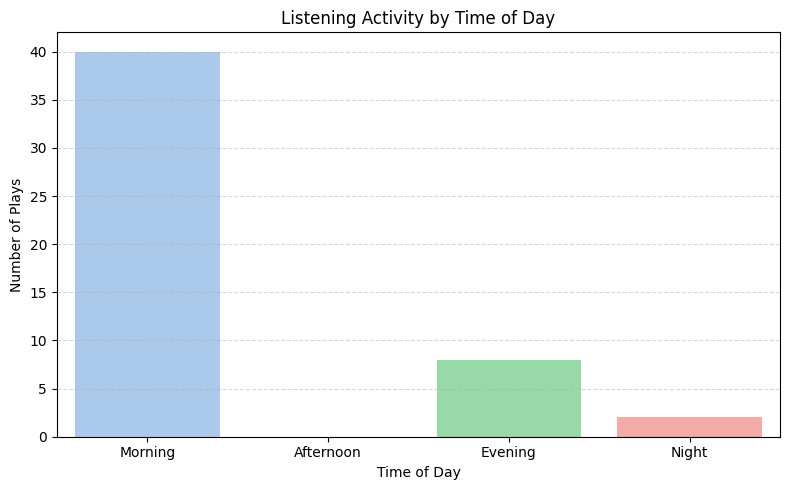

In [235]:
plt.figure(figsize=(8, 5))
order = ['Morning', 'Afternoon', 'Evening', 'Night']
sns.countplot(data=df_recent, x='day_period', order=order, palette='pastel')
plt.title("Listening Activity by Time of Day")
plt.xlabel("Time of Day")
plt.ylabel("Number of Plays")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


In [236]:
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
day_order = ['Morning', 'Afternoon', 'Evening', 'Night']

df_recent['weekday'] = df_recent['weekday'].astype(CategoricalDtype(categories=weekday_order, ordered=True))
df_recent['day_period'] = df_recent['day_period'].astype(CategoricalDtype(categories=day_order, ordered=True))

/var/folders/mv/wk6vx0xn40s4hyxqzh2g2qnm0000gn/T/ipykernel_50088/1755982617.py:1: FutureWarning:

The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior



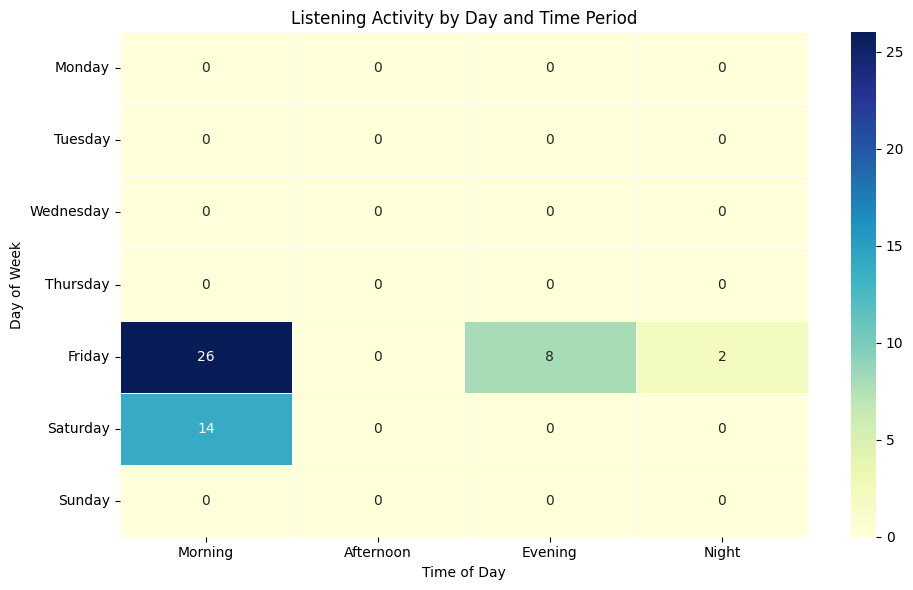

In [237]:
heatmap_data = df_recent.pivot_table(
    index='weekday',
    columns='day_period',
    values='name',
    aggfunc='count',
    fill_value=0
)
plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, cmap='YlGnBu', annot=True, fmt='d', linewidths=0.5)
plt.title("Listening Activity by Day and Time Period")
plt.xlabel("Time of Day")
plt.ylabel("Day of Week")
plt.tight_layout()
plt.show()


In [238]:
# Normalize track and artist names
df_recent['name_clean'] = df_recent['name'].str.lower().str.strip()
df_recent['artist_clean'] = df_recent['artist'].str.lower().str.strip()

df_top_tracks['name_clean'] = df_top_tracks['name'].str.lower().str.strip()
df_top_tracks['artist_clean'] = df_top_tracks['artist'].str.lower().str.strip()

# Repeat rate by track
repeats_tracks = df_recent.merge(df_top_tracks, on=['name_clean', 'artist_clean'], how='inner')
repeat_track_rate = len(repeats_tracks) / len(df_recent) * 100
print(f"Repeat rate by track: {repeat_track_rate:.2f}%")

# Repeat rate by artist
recent_artists = df_recent['artist_clean'].unique()
top_artists = df_top_tracks['artist_clean'].unique()

repeats_artists = set(recent_artists) & set(top_artists)
repeat_artist_rate = len(repeats_artists) / len(recent_artists) * 100
print(f"Repeat rate by artist: {repeat_artist_rate:.2f}%")


Repeat rate by track: 8.00%
Repeat rate by artist: 30.00%


Artists with the most varied follow-ups:
adele             1.0
alpha blondy      1.0
sneaker pimps     1.0
siaka             1.0
radiohead         1.0
mademoiselle k    1.0
lord huron        1.0
little mix        1.0
leonard cohen     1.0
la femme          1.0
dtype: float64


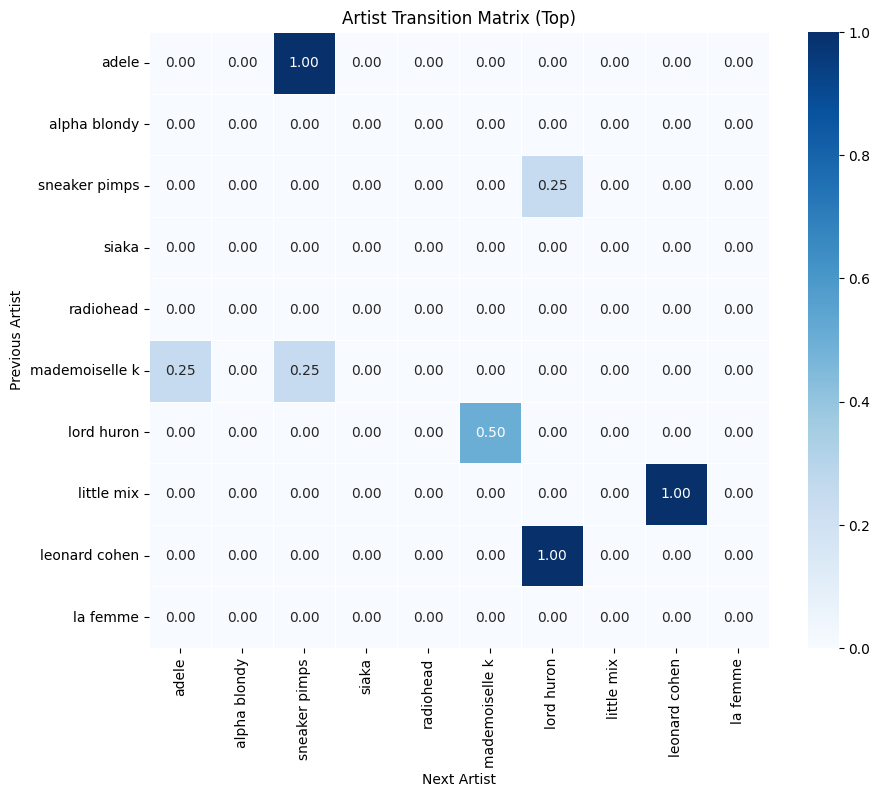

In [239]:
# Sort recent plays in chronological order
df_recent_sorted = df_recent.sort_values(by='played_at')

# Build a list of artist transitions
transitions = list(zip(df_recent_sorted['artist_clean'], df_recent_sorted['artist_clean'][1:]))

# Count artist-to-artist transitions
transition_counts = defaultdict(lambda: defaultdict(int))
for a1, a2 in transitions:
    if a1 != a2:
        transition_counts[a1][a2] += 1

# Create transition matrix
artists = sorted(set(df_recent_sorted['artist_clean']))
transition_matrix = pd.DataFrame(0, index=artists, columns=artists, dtype=float)

for from_artist, to_dict in transition_counts.items():
    total = sum(to_dict.values())
    for to_artist, count in to_dict.items():
        transition_matrix.loc[from_artist, to_artist] = count / total

# Show top 10 artists with the highest number of outgoing transitions
most_transitions = transition_matrix.sum(axis=1).sort_values(ascending=False).head(10)
print("Artists with the most varied follow-ups:")
print(most_transitions)

# Optional: Heatmap of most frequent transitions
top_artists_for_viz = most_transitions.index.tolist()
subset_matrix = transition_matrix.loc[top_artists_for_viz, top_artists_for_viz]

plt.figure(figsize=(10, 8))
sns.heatmap(subset_matrix, annot=True, fmt=".2f", cmap="Blues", linewidths=0.5)
plt.title("Artist Transition Matrix (Top)")
plt.xlabel("Next Artist")
plt.ylabel("Previous Artist")
plt.show()


In [240]:
# Build a dictionary: artist → main genre
artist_to_genre = {}

for _, row in df_top_artists.iterrows():
    genres = row['genres']
    if genres:
        genre = genres[0].lower()
        # Normalize subcategories
        for key in genre_map:
            if key in genre:
                genre = genre_map[key]
                break
        artist_to_genre[row['name'].lower()] = genre
    else:
        artist_to_genre[row['name'].lower()] = 'unknown'

df_recent['genre'] = df_recent['artist'].str.lower().map(artist_to_genre)
df_recent['genre'].fillna('unknown', inplace=True)


/var/folders/mv/wk6vx0xn40s4hyxqzh2g2qnm0000gn/T/ipykernel_50088/2198212844.py:18: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.





In [241]:
# Sort chronologically
df_recent_sorted = df_recent.sort_values(by='played_at')

# Create genre transition pairs
genre_transitions = list(zip(df_recent_sorted['genre'], df_recent_sorted['genre'][1:]))

# Count transitions
transition_counts_genre = defaultdict(lambda: defaultdict(int))

for g1, g2 in genre_transitions:
    if g1 != g2:
        transition_counts_genre[g1][g2] += 1

# Build the genre transition matrix
unique_genres = sorted(set(df_recent_sorted['genre']))
transition_matrix_genre = pd.DataFrame(0, index=unique_genres, columns=unique_genres, dtype=float)

for from_genre, to_dict in transition_counts_genre.items():
    total = sum(to_dict.values())
    for to_genre, count in to_dict.items():
        transition_matrix_genre.loc[from_genre, to_genre] = count / total


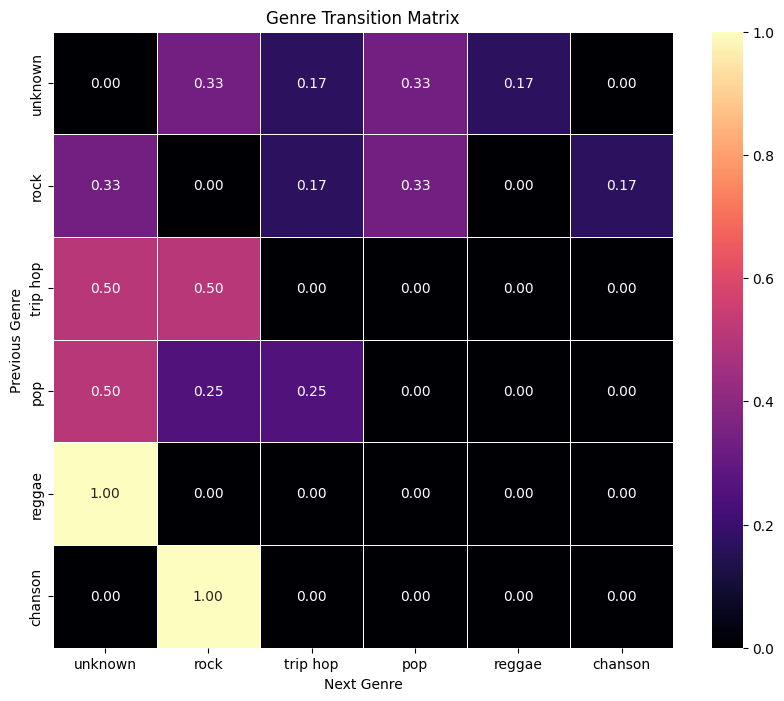

In [242]:
# Keep the most frequent genres for visualization
top_genres = df_recent['genre'].value_counts().head(10).index
transition_subset = transition_matrix_genre.loc[top_genres, top_genres]

plt.figure(figsize=(10, 8))
sns.heatmap(transition_subset, annot=True, fmt=".2f", cmap="magma", linewidths=0.5)
plt.title("Genre Transition Matrix")
plt.xlabel("Next Genre")
plt.ylabel("Previous Genre")
plt.show()


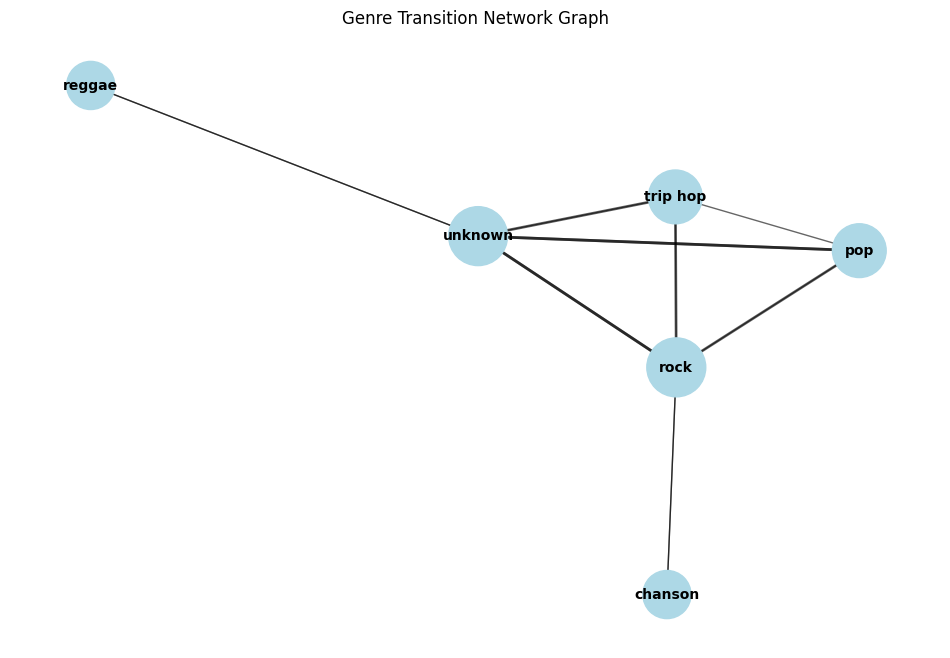

In [243]:
G = nx.DiGraph()

# Add weighted edges between genres
for from_genre, to_dict in transition_counts_genre.items():
    for to_genre, count in to_dict.items():
        G.add_edge(from_genre, to_genre, weight=count)

# Node sizes based on degree (number of connections)
node_sizes = [1000 + 100 * G.degree(node) for node in G.nodes()]
edge_weights = [G[u][v]['weight'] for u, v in G.edges()]

# Node positioning
pos = nx.spring_layout(G, seed=42)

plt.figure(figsize=(12, 8))
nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color="lightblue")
nx.draw_networkx_edges(G, pos, width=edge_weights, alpha=0.6, arrows=True)
nx.draw_networkx_labels(G, pos, font_size=10, font_weight='bold')

plt.title("Genre Transition Network Graph")
plt.axis("off")
plt.show()


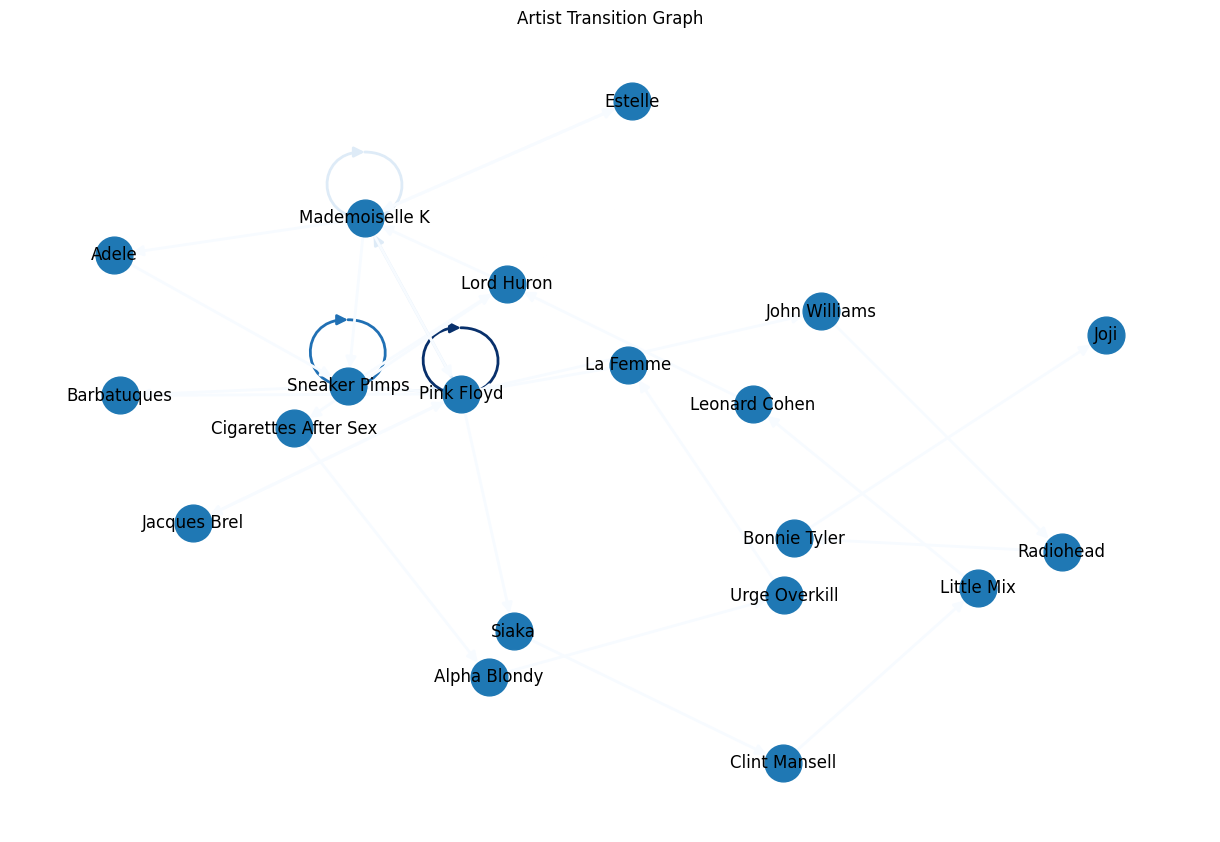

In [244]:
# Get the list of artists in chronological order of listening
artist_sequence = df_recent.sort_values("played_at")['artist'].tolist()

# Count successive transitions between artists
transition_counts = {}
for a1, a2 in pairwise(artist_sequence):
    if (a1, a2) in transition_counts:
        transition_counts[(a1, a2)] += 1
    else:
        transition_counts[(a1, a2)] = 1

# Create a directed graph
G = nx.DiGraph()
for (a1, a2), weight in transition_counts.items():
    G.add_edge(a1, a2, weight=weight)

# Display the graph
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G, k=0.7, seed=42)
edges = G.edges()
weights = [G[u][v]['weight'] for u, v in edges]
nx.draw(
    G, pos,
    with_labels=True,
    node_size=700,
    edge_color=weights,
    edge_cmap=plt.cm.Blues,
    width=2,
    arrowsize=15
)
plt.title("Artist Transition Graph")
plt.show()

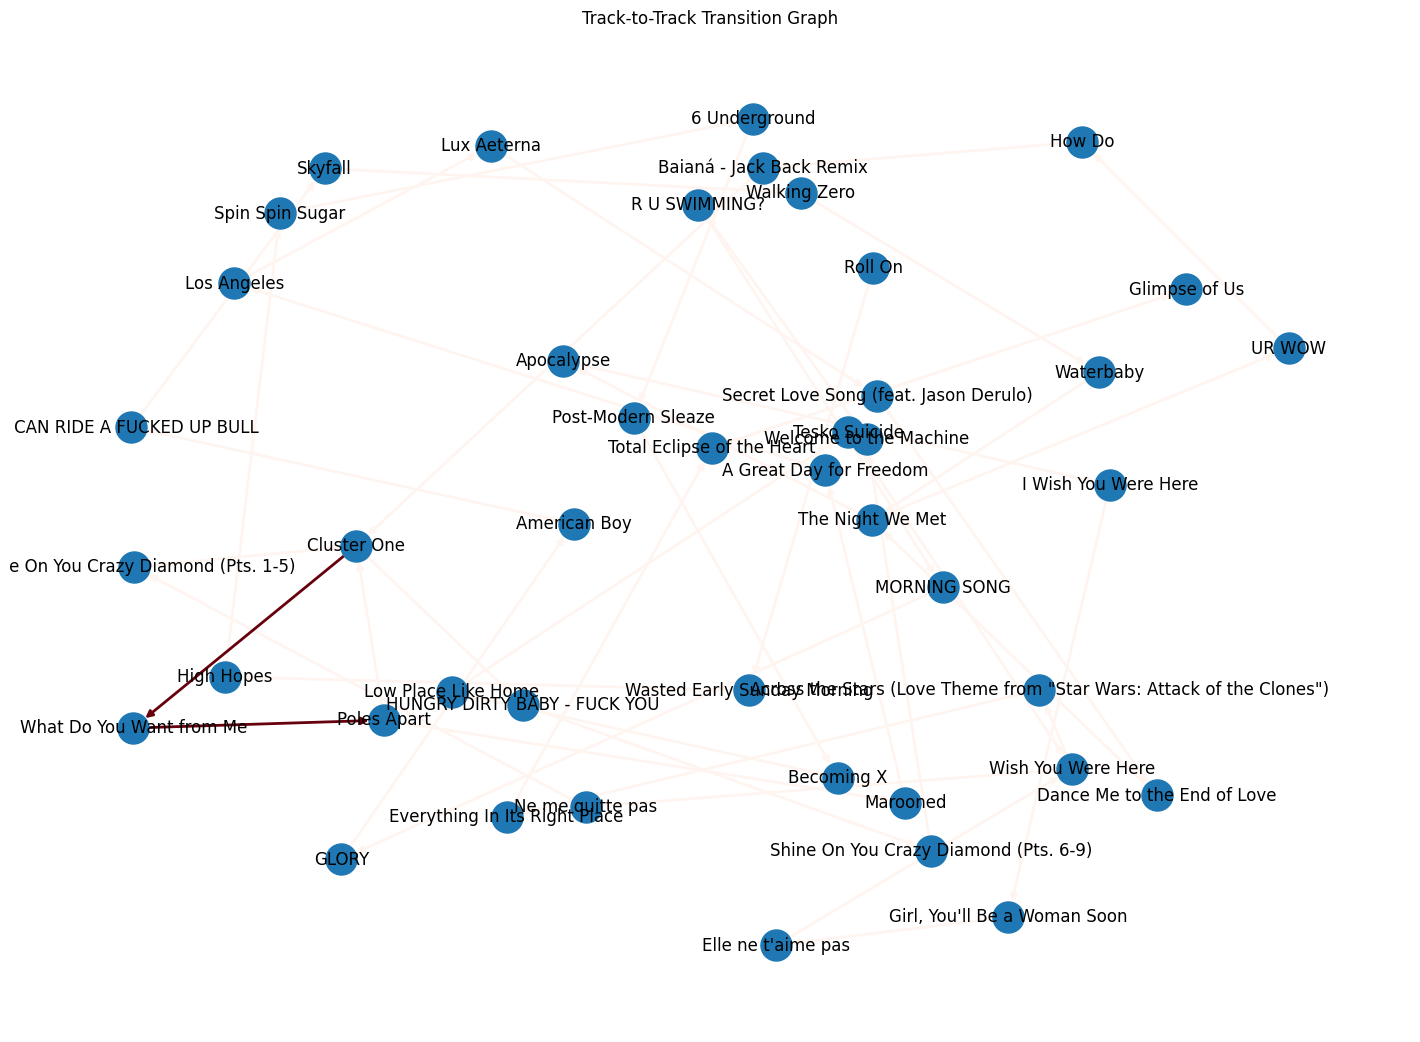

In [245]:
track_sequence = df_recent.sort_values("played_at")['name'].tolist()

transition_counts = {}
for t1, t2 in pairwise(track_sequence):
    if (t1, t2) in transition_counts:
        transition_counts[(t1, t2)] += 1
    else:
        transition_counts[(t1, t2)] = 1

G = nx.DiGraph()
for (t1, t2), weight in transition_counts.items():
    G.add_edge(t1, t2, weight=weight)

plt.figure(figsize=(14, 10))
pos = nx.spring_layout(G, k=0.8, seed=42)
weights = [G[u][v]['weight'] for u, v in G.edges()]
nx.draw(G, pos, with_labels=True, node_size=500, edge_color=weights, edge_cmap=plt.cm.Reds, width=2, arrowsize=10)
plt.title("Track-to-Track Transition Graph")
plt.show()


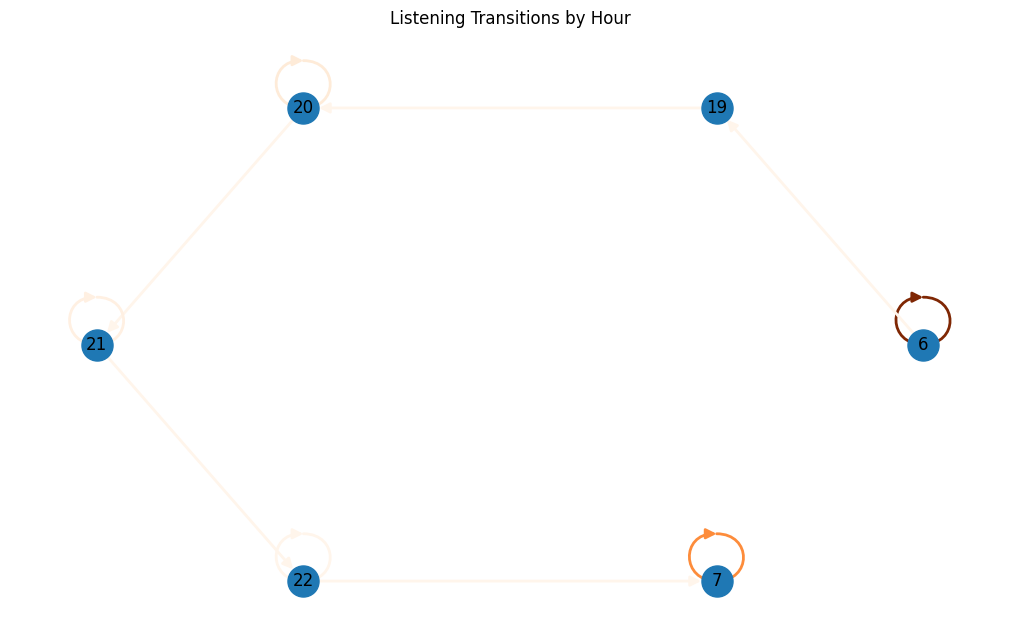

In [246]:
hour_sequence = df_recent.sort_values("played_at")['hour'].tolist()

transition_counts = {}
for h1, h2 in pairwise(hour_sequence):
    if (h1, h2) in transition_counts:
        transition_counts[(h1, h2)] += 1
    else:
        transition_counts[(h1, h2)] = 1

G = nx.DiGraph()
for (h1, h2), weight in transition_counts.items():
    G.add_edge(h1, h2, weight=weight)

plt.figure(figsize=(10, 6))
pos = nx.circular_layout(G)
weights = [G[u][v]['weight'] for u, v in G.edges()]
nx.draw(G, pos, with_labels=True, node_size=500, edge_color=weights, edge_cmap=plt.cm.Oranges, width=2, arrowsize=15)
plt.title("Listening Transitions by Hour")
plt.show()


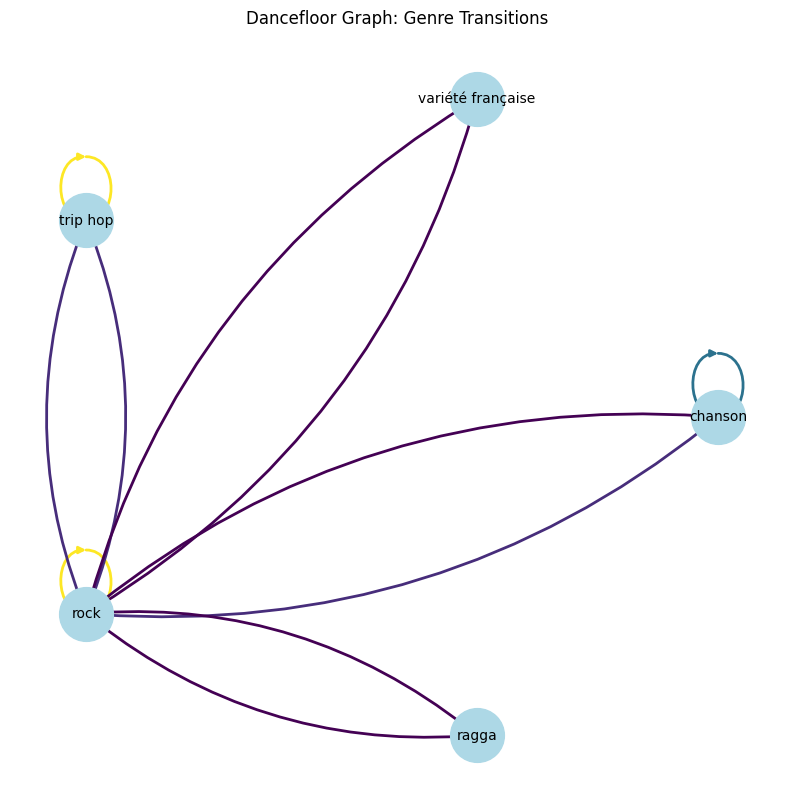

In [247]:
# Assuming df_recent and df_top_artists are already available
# And df_recent contains 'played_at', 'hour', and 'artist' columns

# Create mapping from artist to main genre
artist_genre_map = {}
for _, row in df_top_artists.iterrows():
    for genre in row['genres']:
        genre_lower = genre.lower()
        for keyword, label in genre_map.items():
            if keyword in genre_lower:
                artist_genre_map[row['name']] = label
                break
        else:
            artist_genre_map[row['name']] = genre_lower

# Add genre column to df_recent
df_recent['genre'] = df_recent['artist'].map(artist_genre_map)

# Drop rows with unknown genre
df_recent.dropna(subset=['genre'], inplace=True)

# Build genre transitions
genre_transitions = list(zip(df_recent['genre'][:-1], df_recent['genre'][1:]))
transition_counts = Counter(genre_transitions)

# Create circular layout graph
G = nx.DiGraph()
for (source, target), weight in transition_counts.items():
    G.add_edge(source, target, weight=weight)

# Place genres in a circle
unique_genres = list(set([g for pair in genre_transitions for g in pair]))
angle_step = 2 * np.pi / len(unique_genres)
positions = {genre: (np.cos(i * angle_step), np.sin(i * angle_step)) for i, genre in enumerate(unique_genres)}

# Draw the graph
plt.figure(figsize=(10, 10))
edges = G.edges(data=True)
weights = [d['weight'] for (_, _, d) in edges]

nx.draw_networkx_nodes(G, positions, node_size=1500, node_color='lightblue')
nx.draw_networkx_labels(G, positions, font_size=10)
nx.draw_networkx_edges(
    G,
    positions,
    edge_color=weights,
    edge_cmap=plt.cm.viridis,
    edge_vmin=min(weights),
    edge_vmax=max(weights),
    arrows=True,
    width=2,
    connectionstyle='arc3,rad=0.2'
)

plt.title("Dancefloor Graph: Genre Transitions")
plt.axis('off')
plt.show()


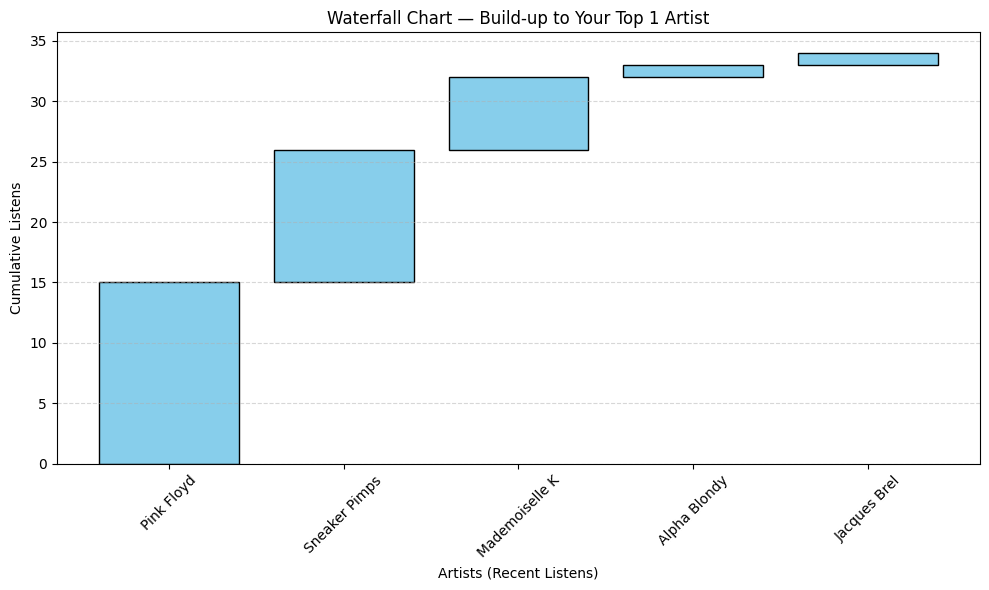

In [248]:
# Step 1: Count recent listens by artist
artist_counts = df_recent['artist'].value_counts()

# Step 2: Keep the top N contributors
top_n = 10
artist_counts = artist_counts.head(top_n)

# Step 3: Build the DataFrame for the waterfall
df_waterfall = artist_counts.reset_index()
df_waterfall.columns = ['artist', 'count']
df_waterfall['cumulative'] = df_waterfall['count'].cumsum()
df_waterfall['start'] = df_waterfall['cumulative'] - df_waterfall['count']

# Step 4: Plotting
plt.figure(figsize=(10, 6))
for i in range(len(df_waterfall)):
    plt.bar(
        df_waterfall['artist'][i],
        df_waterfall['count'][i],
        bottom=df_waterfall['start'][i],
        color='skyblue',
        edgecolor='black'
    )

plt.title("Waterfall Chart — Build-up to Your Top 1 Artist")
plt.xlabel("Artists (Recent Listens)")
plt.ylabel("Cumulative Listens")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


In [249]:
def get_top_tracks(period, limit=50):
    results = sp.current_user_top_tracks(limit=limit, time_range=period)
    return [f"{item['name']} — {item['artists'][0]['name']}" for item in results['items']]

In [250]:
top_tracks_short = get_top_tracks('short_term')
top_tracks_medium = get_top_tracks('medium_term')
top_tracks_long = get_top_tracks('long_term')


In [251]:
df_tracks_compare = pd.DataFrame({
    'short_term': pd.Series(top_tracks_short),
    'medium_term': pd.Series(top_tracks_medium),
    'long_term': pd.Series(top_tracks_long)
})

print("Tracks:")
print(df_tracks_compare)


Tracks:
                                           short_term  \
0                          My Favourite Game — Odymel   
1                Afterimage - Justice Remix — Justice   
2     Ce monde où tu n'existes pas — ascendant vierge   
3                          Violin Sonata No13 — Majes   
4                                  KYKY2BONDY — Hamza   
5                              Sunrise - Edit — Movin   
6          La symphonie des éclairs — Zaho de Sagazan   
7                 I Wish You Were Here — Alpha Blondy   
8                              Atlantis — Netherworld   
9                      What A Life — Scarlet Pleasure   
10                 L'Amour Toujours — Gigi D'Agostino   
11               Can't Take My Eyes off You — Craymer   
12                            Happy Together — Weezer   
13   It Feels So Good - Jamy Nox Remix — Matt Sassari   
14                                   Winter — Leblanc   
15       Girl, You'll Be a Woman Soon — Urge Overkill   
16                     

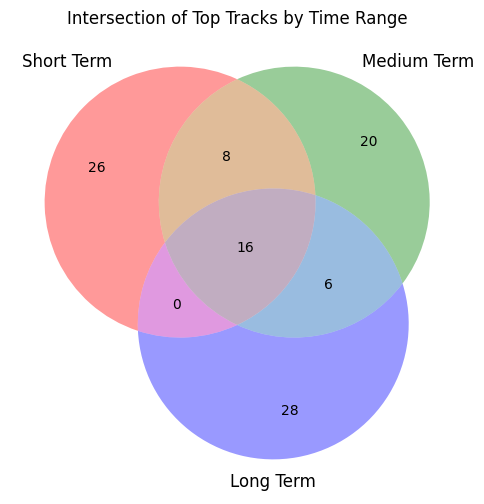

In [252]:
set_short = set(top_tracks_short)
set_medium = set(top_tracks_medium)
set_long = set(top_tracks_long)

plt.figure(figsize=(8, 6))
venn3([set_short, set_medium, set_long], set_labels=('Short Term', 'Medium Term', 'Long Term'))
plt.title("Intersection of Top Tracks by Time Range")
plt.show()


In [253]:
intersection_all = set_short & set_medium & set_long
only_short = set_short - (set_medium | set_long)
only_medium = set_medium - (set_short | set_long)
only_long = set_long - (set_short | set_medium)

print("Present in all time ranges:")
print("\n".join(intersection_all))

print("\nOnly in Short Term:")
print("\n".join(only_short))

print("\nOnly in Medium Term:")
print("\n".join(only_medium))

print("\nOnly in Long Term:")
print("\n".join(only_long))


Present in all time ranges:
Across the Stars (Love Theme from "Star Wars: Attack of the Clones") — John Williams
Jimmy — Moriarty
Ambre — Nils Frahm
Comptine d'un autre été, l'après-midi — Yann Tiersen
L'oiseau et l'enfant — Marie Myriam
Le vent nous portera — Sophie Hunger
I Wish You Were Here — Alpha Blondy
Ne me quitte pas — Jacques Brel
Lettre à Élise — Ludwig van Beethoven
Vois sur ton chemin — Bruno Coulais
Girl, You'll Be a Woman Soon — Urge Overkill
L'aigle noir — Barbara
Hallelujah — Jeff Buckley
Happy Together — Weezer
Mystery of Love — Sufjan Stevens
Come Away With Me — Norah Jones

Only in Short Term:
Sunrise - Edit — Movin
Radio Ga Ga - Remastered 2011 — Queen
Harder, Better, Faster, Stronger — Daft Punk
Atlantis — Netherworld
Winter — Leblanc
Now We Are Free — Leblanc
Shine On You Crazy Diamond (Pts. 1-5) — Pink Floyd
Murder On The Dancefloor — Sophie Ellis-Bextor
What A Life — Scarlet Pleasure
Dies Irae — Leblanc
On va s'aimer — Gilbert Montagné
Gucci — Odymel
Violin Son

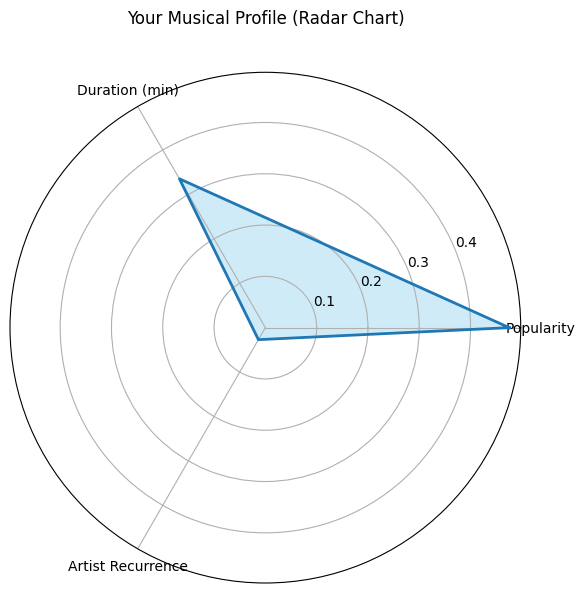

In [254]:
# Step 1: Compute average metrics
avg_popularity = df_top_tracks['popularity'].mean()
avg_duration = df_top_tracks['duration_min'].mean()
avg_artist_frequency = df_top_tracks['artist'].value_counts(normalize=True).mean()

# Step 2: Normalize metrics between 0 and 1
metrics = {
    'Popularity': avg_popularity / 100,
    'Duration (min)': avg_duration / df_top_tracks['duration_min'].max(),
    'Artist Recurrence': avg_artist_frequency
}

# Step 3: Format for radar chart
labels = list(metrics.keys())
values = list(metrics.values())
values += values[:1]  # to close the loop

# Radar chart
plt.figure(figsize=(6, 6))
angles = [n / float(len(labels)) * 2 * pi for n in range(len(labels))]
angles += angles[:1]

ax = plt.subplot(111, polar=True)
plt.xticks(angles[:-1], labels)

ax.plot(angles, values, linewidth=2, linestyle='solid')
ax.fill(angles, values, 'skyblue', alpha=0.4)

plt.title("Your Musical Profile (Radar Chart)", y=1.08)
plt.tight_layout()
plt.show()


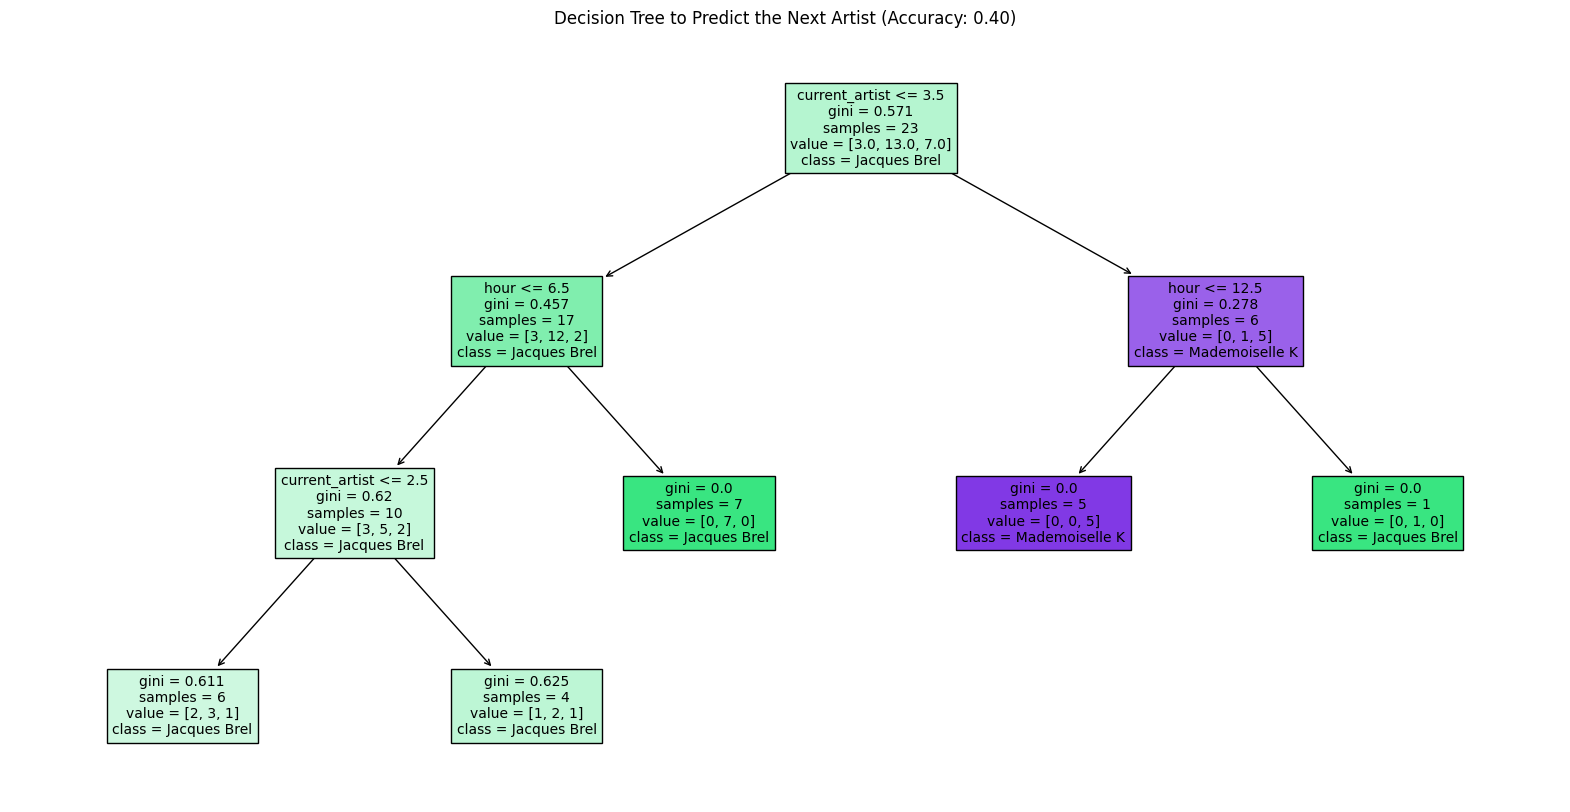

In [255]:
# Clean recent listening DataFrame
df_recent_clean = df_recent[['played_at', 'artist', 'hour', 'weekday']].copy()
df_recent_clean = df_recent_clean.sort_values('played_at').reset_index(drop=True)

# Create a shifted column to simulate transitions to the next artist
df_recent_clean['next_artist'] = df_recent_clean['artist'].shift(-1)

# Drop rows with missing values
df_model = df_recent_clean.dropna(subset=['next_artist']).copy()

# Encode categorical variables
weekday_enc = LabelEncoder()
artist_enc = LabelEncoder()
next_artist_enc = LabelEncoder()

df_model['weekday_enc'] = weekday_enc.fit_transform(df_model['weekday'])
df_model['artist_enc'] = artist_enc.fit_transform(df_model['artist'])
df_model['next_artist_enc'] = next_artist_enc.fit_transform(df_model['next_artist'])

# Define features and target
X = df_model[['hour', 'weekday_enc', 'artist_enc']]
y = df_model['next_artist_enc']

# Train/test split and model fitting
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

tree_clf = DecisionTreeClassifier(max_depth=4, random_state=42)
tree_clf.fit(X_train, y_train)

# Evaluate and plot the decision tree
y_pred = tree_clf.predict(X_test)
acc = accuracy_score(y_test, y_pred)

plt.figure(figsize=(20, 10))
plot_tree(
    tree_clf,
    feature_names=["hour", "weekday", "current_artist"],
    class_names=next_artist_enc.classes_,
    filled=True,
    fontsize=10
)
plt.title(f"Decision Tree to Predict the Next Artist (Accuracy: {acc:.2f})")
plt.show()


In [256]:
def part_of_day(hour):
    if 5 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 17:
        return 'Afternoon'
    elif 17 <= hour < 22:
        return 'Evening'
    else:
        return 'Night'

df_recent['part_of_day'] = df_recent['hour'].apply(part_of_day)


In [257]:
df_features = df_recent.merge(
    df_top_tracks[['name', 'duration_min', 'popularity']],
    on='name',
    how='left'
)


In [258]:
# Encode part of day
le_part = LabelEncoder()
df_features['part_encoded'] = le_part.fit_transform(df_features['part_of_day'])

# Encode weekday
le_day = LabelEncoder()
df_features['weekday_encoded'] = le_day.fit_transform(df_features['weekday'])

# Encode artist (target)
le_artist = LabelEncoder()
df_features['artist_encoded'] = le_artist.fit_transform(df_features['artist'])


In [259]:
features = ['part_encoded', 'weekday_encoded', 'duration_min', 'popularity_y']
X = df_features[features]
y = df_features['artist_encoded']


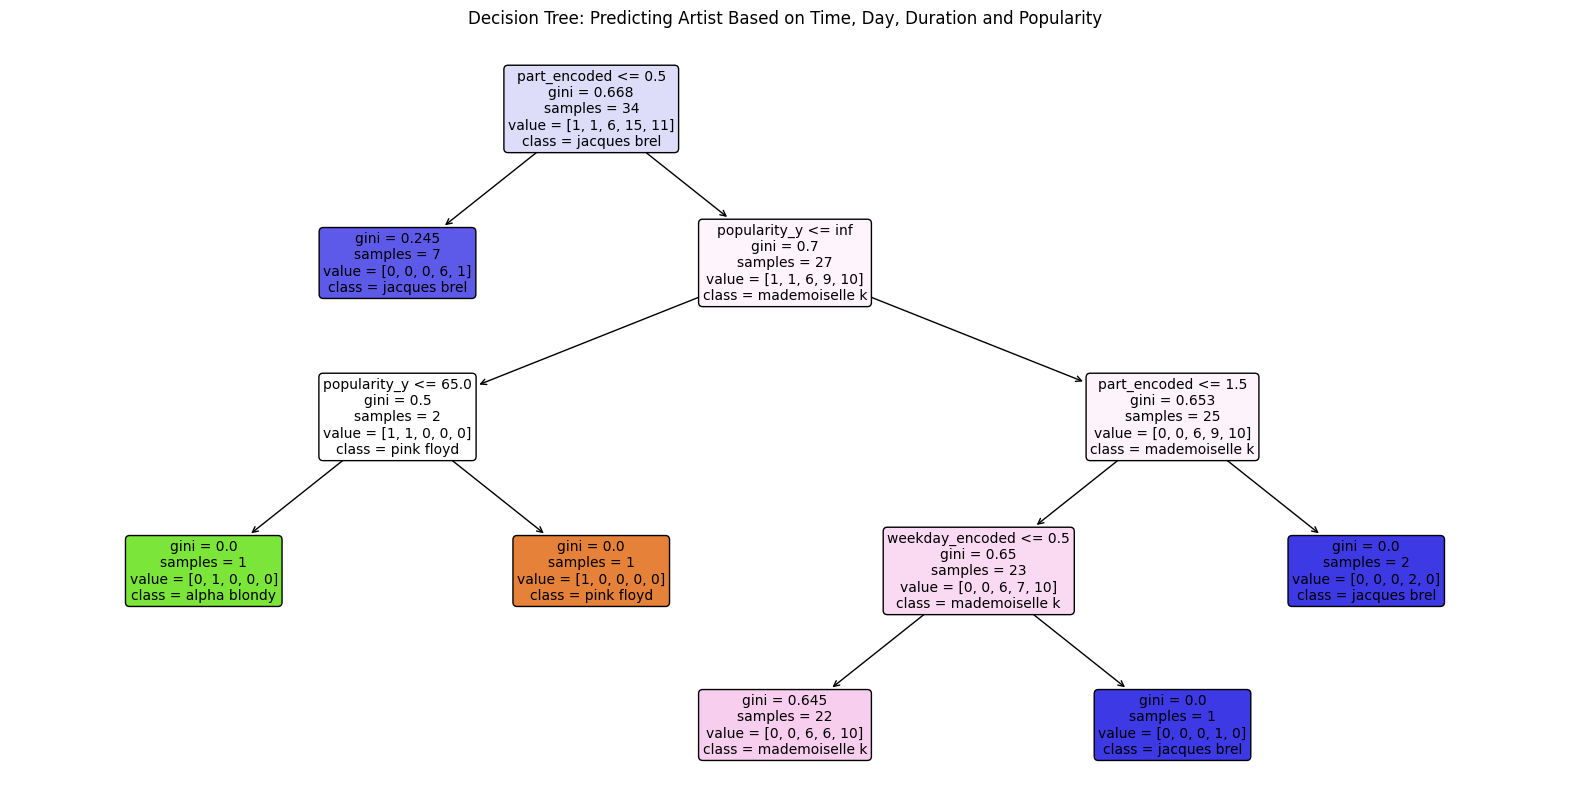

In [260]:
# Features and target
features = ['part_encoded', 'weekday_encoded', 'duration_min', 'popularity_y']
X = df_features[features]
y = df_features['artist_encoded']

# Train the model
tree_clf = DecisionTreeClassifier(max_depth=5, random_state=42)
tree_clf.fit(X, y)

# Display the decision tree
plt.figure(figsize=(20, 10))
plot_tree(tree_clf,
          feature_names=features,
          class_names=df_features['artist_clean'].astype(str).unique(),
          filled=True,
          rounded=True,
          fontsize=10)
plt.title("Decision Tree: Predicting Artist Based on Time, Day, Duration and Popularity")
plt.show()


In [261]:
def get_country_from_musicbrainz(artist_name):
    try:
        url = f"https://musicbrainz.org/ws/2/artist/?query=artist:{artist_name}&fmt=json"
        response = requests.get(url, headers={'User-Agent': 'MusicGeoMapper/1.0'})
        if response.status_code == 200:
            results = response.json().get('artists', [])
            if results:
                return results[0].get('country')
        return None
    except:
        return None


df_top_artists['country'] = df_top_artists['name'].apply(get_country_from_musicbrainz)
time.sleep(1)


In [262]:
country_counts = df_top_artists['country'].value_counts().reset_index()
country_counts.columns = ['country', 'count']


In [263]:
# Function to retrieve country from MusicBrainz
def get_country_from_musicbrainz(artist_name):
    try:
        url = f"https://musicbrainz.org/ws/2/artist/?query=artist:{artist_name}&fmt=json"
        response = requests.get(url, headers={'User-Agent': 'MusicGeoMapper/1.0'})
        if response.status_code == 200:
            results = response.json().get('artists', [])
            if results:
                return results[0].get('country')  # Alpha-2 country code
        return None
    except:
        return None

# Apply the function to each artist name (slow process - do not spam)
df_top_artists['country_alpha2'] = df_top_artists['name'].apply(get_country_from_musicbrainz)
time.sleep(1)  # minimal pause to limit request rate

# Convert Alpha-2 codes to Alpha-3 for Plotly choropleth compatibility
def alpha2_to_alpha3(code):
    try:
        return pycountry.countries.get(alpha_2=code).alpha_3
    except:
        return None

df_top_artists['country_alpha3'] = df_top_artists['country_alpha2'].apply(alpha2_to_alpha3)

# Count number of artists per country
country_counts = df_top_artists['country_alpha3'].value_counts().reset_index()
country_counts.columns = ['country', 'count']

# Plot the choropleth map
fig = px.choropleth(
    country_counts,
    locations='country',
    locationmode='ISO-3',
    color='count',
    color_continuous_scale='Viridis',
    title='Number of Artists by Country of Origin'
)
fig.show()
